# System Threat Forecaster 

The goal of this competition is to predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.

# Basic Setup

In [86]:
#Imports

import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler

In [14]:
pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


In [6]:
df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv") 

# Data Observations

In [7]:
df.shape

(100000, 76)

In [8]:
df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [9]:
num = df.select_dtypes(include=['int64', 'float64']).columns
cat = df.select_dtypes(include=['object']).columns

print("Total numerical columns: ", len(num))
print("Total categorical columns:", len(cat))

Total numerical columns:  48
Total categorical columns: 28


# Exploratory Data Analysis (EDA)

In [10]:
df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,...,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,...,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,...,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,...,556.000000,52357.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


## Data Imbalance?

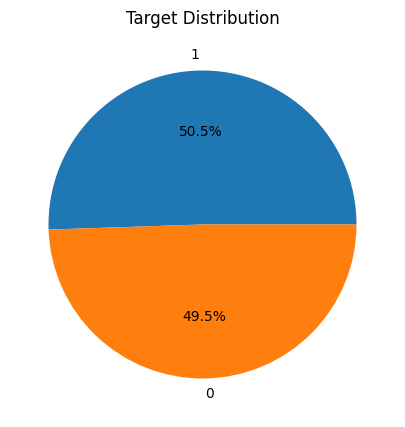

In [9]:
plt.figure(figsize=(8, 5))
target = df['target'].value_counts ()
plt.pie(target, labels=target.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

There is no data imbalance in the dataset. This implies the following

* Almost 50.5% of the devices got infected as indicated by label - 1
* Around 49.5% of the devices didn't infected as indicated by label - 0

## Antivirus Used

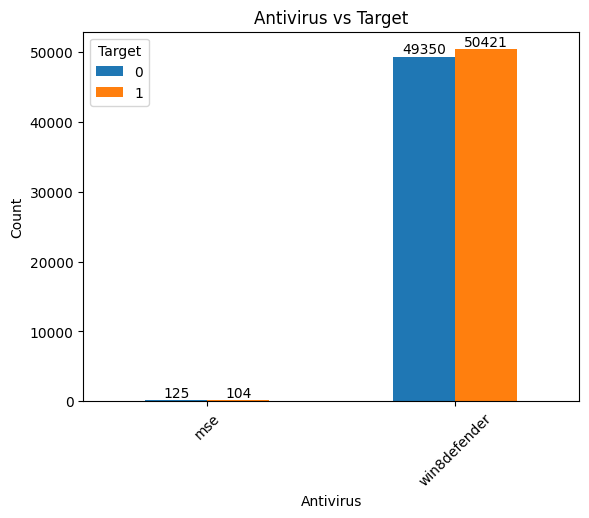

In [10]:
graph = df.groupby(["ProductName", "target"]).size().unstack()
ax = graph.plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("Antivirus")
plt.ylabel("Count")
plt.title("Antivirus vs Target")
plt.xticks(rotation=45)
plt.legend(title="Target")
plt.show()

Most devices use Windows Defender and infection rates (label-1, orange color) are around 50%. MSE (now defunct) has 45% of infection (label-0, orange color) but has been rarely used across devices.

## Platform Type

In [11]:
df["PlatformType"].value_counts()

PlatformType
windows10      98344
windows8        1401
windows7         226
windows2016       29
Name: count, dtype: int64

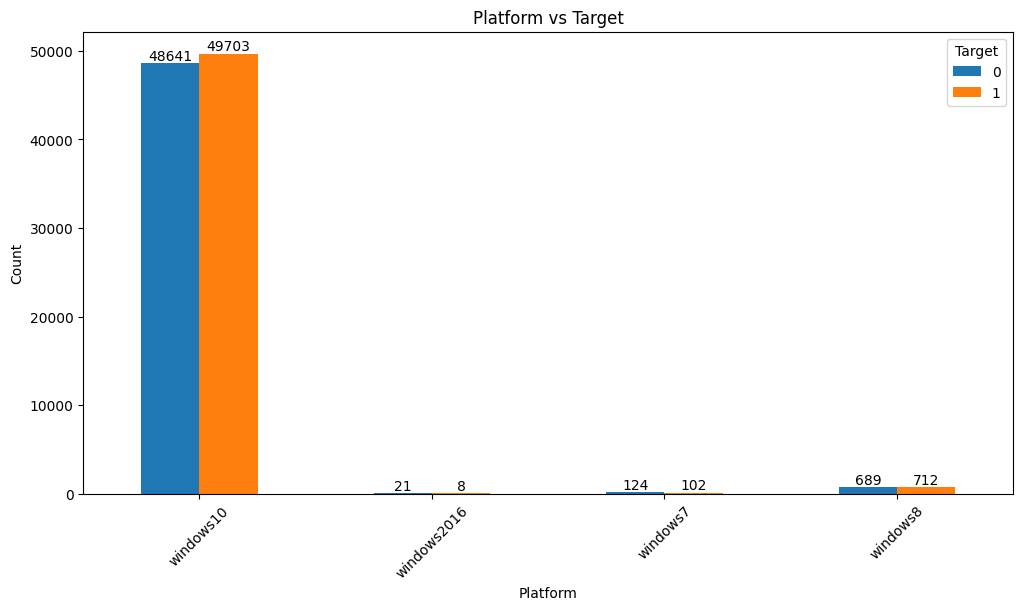

In [12]:
graph = df.groupby(["PlatformType", 'target']).size().unstack()
ax = graph.plot(kind="bar", figsize=(12, 6))
for y in ax.containers:
    ax.bar_label(y)
plt.xlabel("Platform")
plt.ylabel("Count")
plt.title("Platform vs Target")
plt.xticks(rotation=45)
plt.legend(title="Target")
plt.show()

Here majority of the devices in the dataset have Windows 10 as their device with around 50% infection rate. 

## Display Size

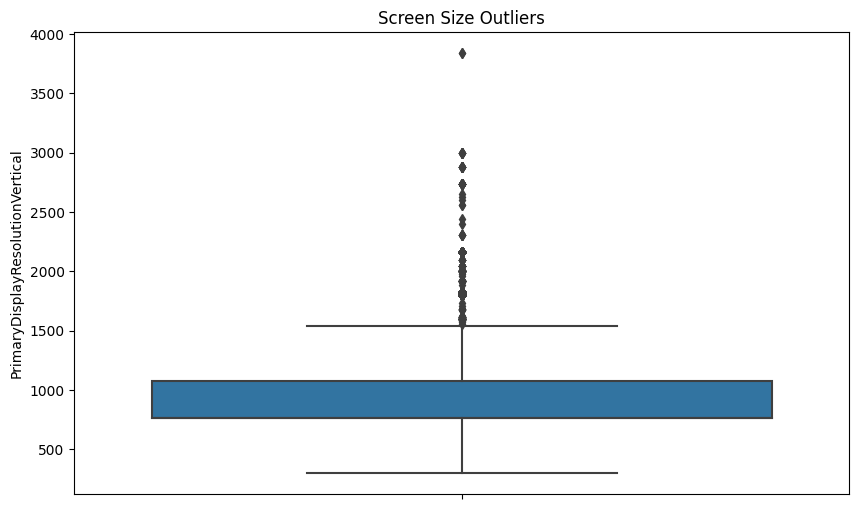

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='PrimaryDisplayResolutionVertical', data=df)
plt.title('Screen Size Outliers' )
plt.show()

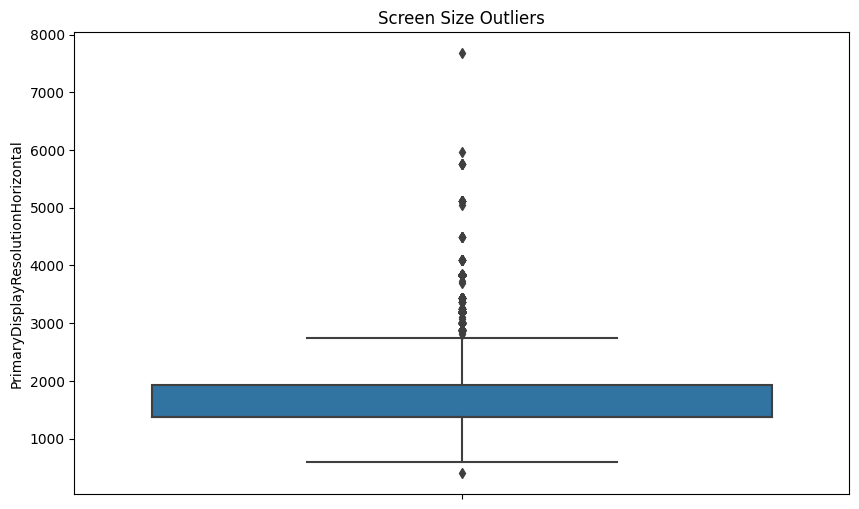

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='PrimaryDisplayResolutionHorizontal', data=df)
plt.title('Screen Size Outliers' )
plt.show()

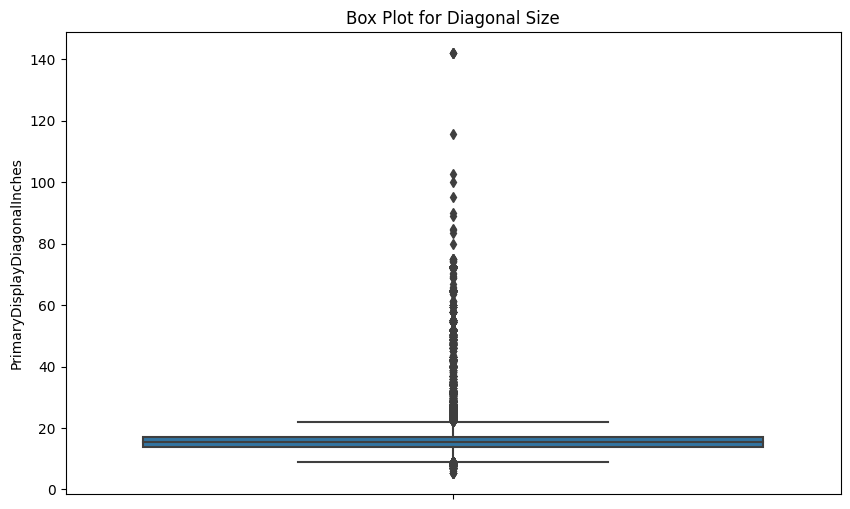

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(y="PrimaryDisplayDiagonalInches", data=df)
plt.title("Box Plot for Diagonal Size")
plt.show()

This boxplot signifies that majority of the devices have verticle & horizontal size between 500-1000 & 1000-2000 respectively with a lot of outliers

## GeoRegionID

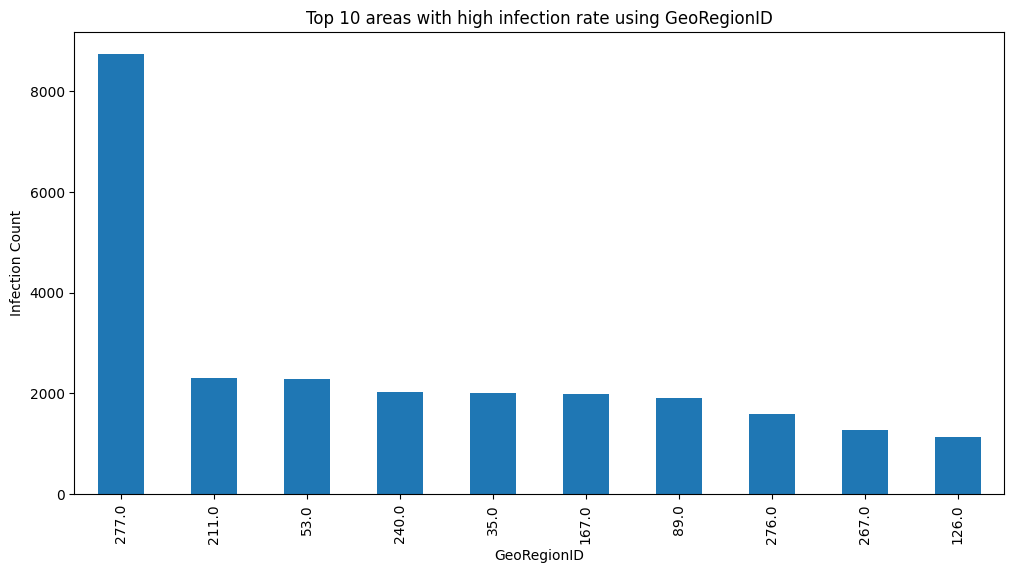

In [16]:
geo_counts = df['GeoRegionID'].value_counts()

infection_rates = df[df['target'] == 1].groupby('GeoRegionID').size().nlargest(10)
ax = infection_rates.plot(kind='bar', figsize=(12, 6))
ax.set_xlabel("GeoRegionID")
ax.set_ylabel("Infection Count")
ax.set_title("Top 10 areas with high infection rate using GeoRegionID")
plt.xticks(rotation=90)
plt.show()

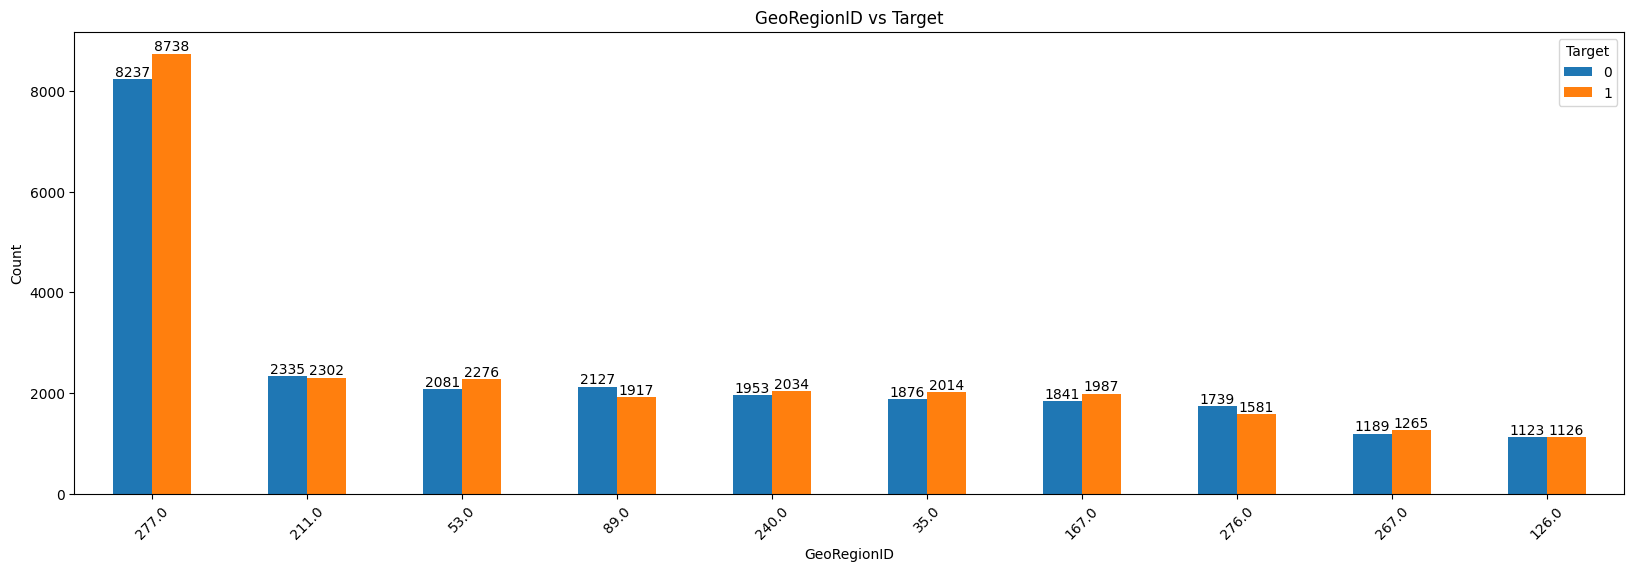

In [17]:
graph = df.groupby(["GeoRegionID", "target"]).size().unstack()
graph = graph.loc[graph.sum(axis=1).nlargest(10).index]

ax = graph.plot(kind="bar", figsize=(20, 6))
for y in ax.containers:
    ax.bar_label(y)

plt.xlabel("GeoRegionID")
plt.ylabel("Count")
plt.title("GeoRegionID vs Target")
plt.xticks(rotation=45)
plt.legend(title="Target")
plt.show()

We can see that GeoRegionID 277 has > 51% infection rate as well as most devices are from that region.

## IsGamer

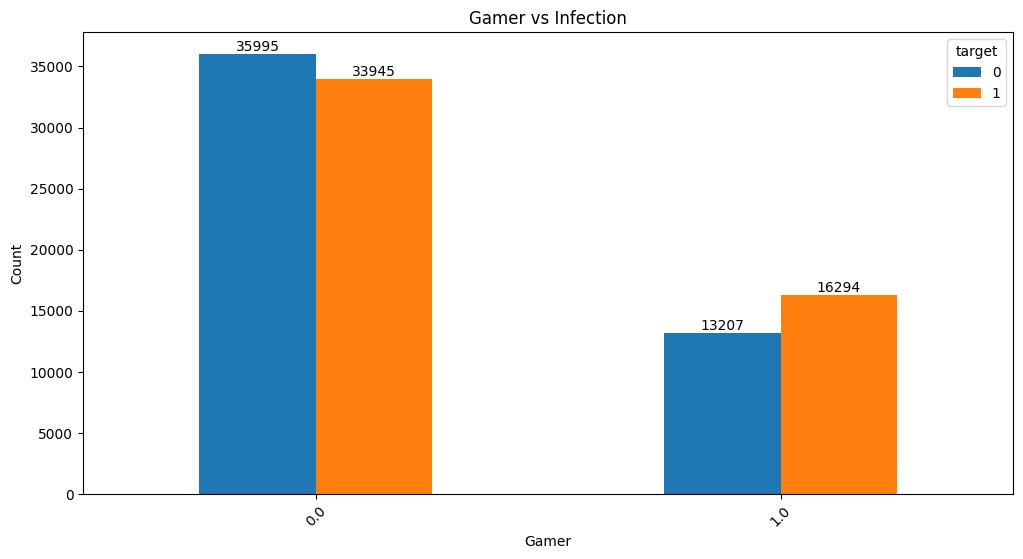

In [18]:
graph = df.groupby(['IsGamer','target']).size().unstack()
ax = graph.plot(kind="bar", figsize=(12,6))
for y in ax.containers:
    ax.bar_label(y)
plt.xlabel("Gamer")
plt.ylabel("Count")
plt.title("Gamer vs Infection")
plt.xticks(rotation=45)
plt.legend(title="target")
plt.show()

Here we see that, 
* When IsGamer is 0, that is the person not a gamer, infection rates are a little lower around 48% 
* When IsGamer is 1, infection rates are 55% 

## System Protection

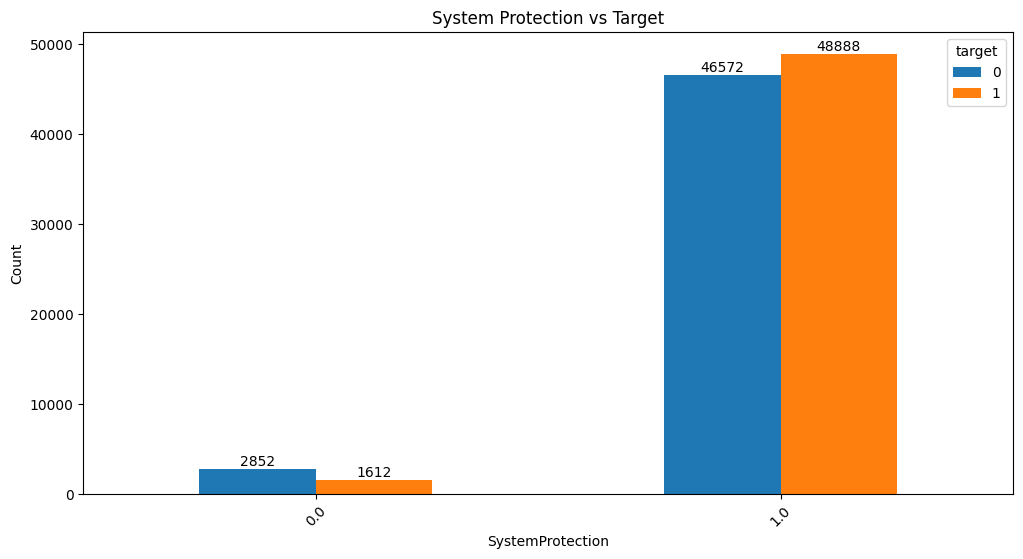

In [19]:
graph = df.groupby(['IsSystemProtected','target']).size().unstack()
ax = graph.plot(kind="bar", figsize=(12,6))
for y in ax.containers:
    ax.bar_label(y)
plt.xlabel("SystemProtection")
plt.ylabel("Count")
plt.title("System Protection vs Target")
plt.xticks(rotation=45)
plt.legend(title="target")
plt.show()

When the system was not protected the number of infections seem to be less when compared to system protection ON (1) 

# Date & Time (Date_AS & Date_OS)

In [11]:
df['DateAS'] = pd.to_datetime(df['DateAS'])
df['DateOS'] = pd.to_datetime(df['DateOS'])

df['DateAS_year'] = df['DateAS'].dt.year
df['DateAS_month'] = df['DateAS'].dt.month
df['DateAS_day'] = df['DateAS'].dt.dayofweek

df['DateOS_year'] = df['DateOS'].dt.year
df['DateOS_month'] = df['DateOS'].dt.month
df['DateOS_day'] = df['DateOS'].dt.dayofweek

## Year

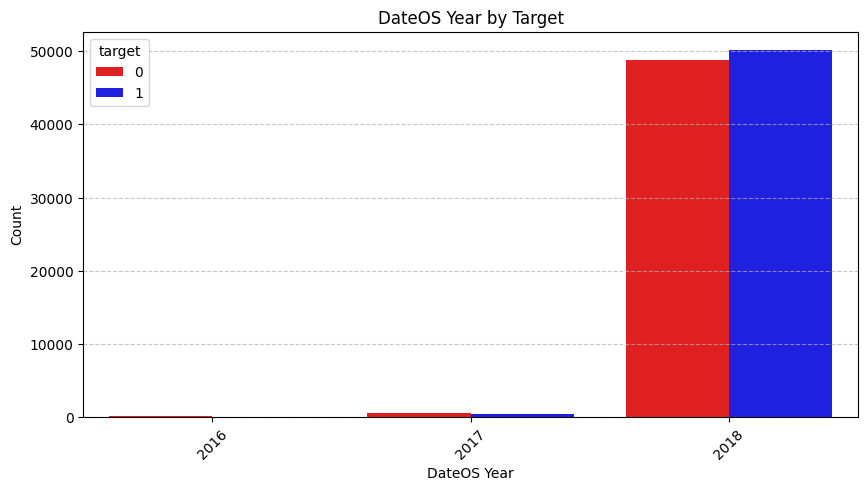

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateAS_year', hue='target', palette=['red','blue'])

plt.xlabel("DateOS Year")
plt.ylabel("Count")
plt.title("DateOS Year by Target")
plt.legend(title="target", labels=["0","1"])

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

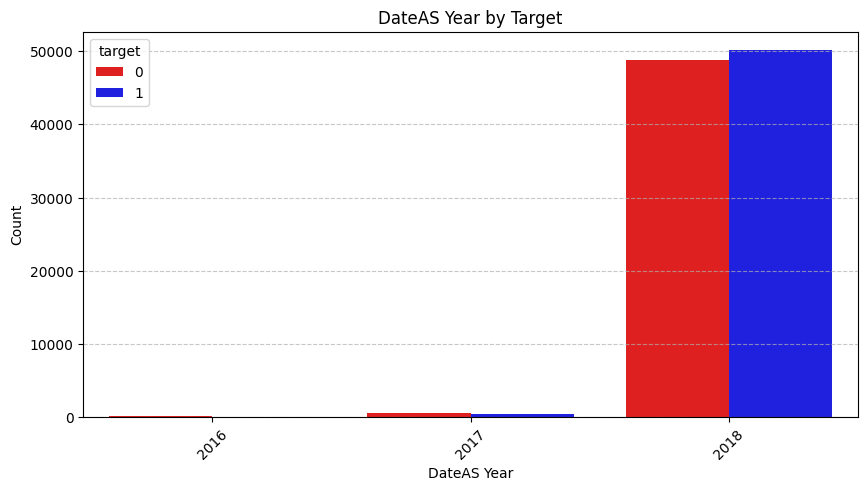

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateAS_year', hue='target', palette=['red','blue'])

plt.xlabel("DateAS Year")
plt.ylabel("Count")
plt.title("DateAS Year by Target")
plt.legend(title="target", labels=["0","1"])

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Month

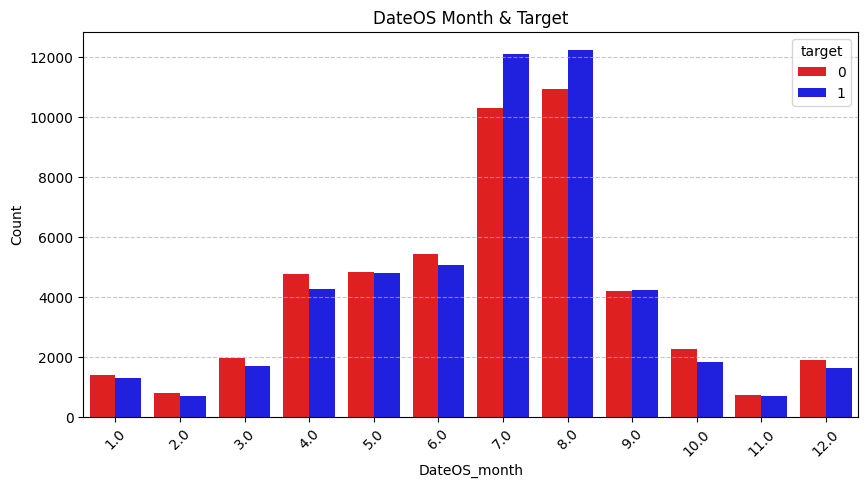

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateOS_month', hue='target', palette=['red','blue'])

plt.xlabel("DateOS_month")
plt.ylabel("Count")
plt.title("DateOS Month & Target")
plt.legend(title="target", labels=["0","1"])

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

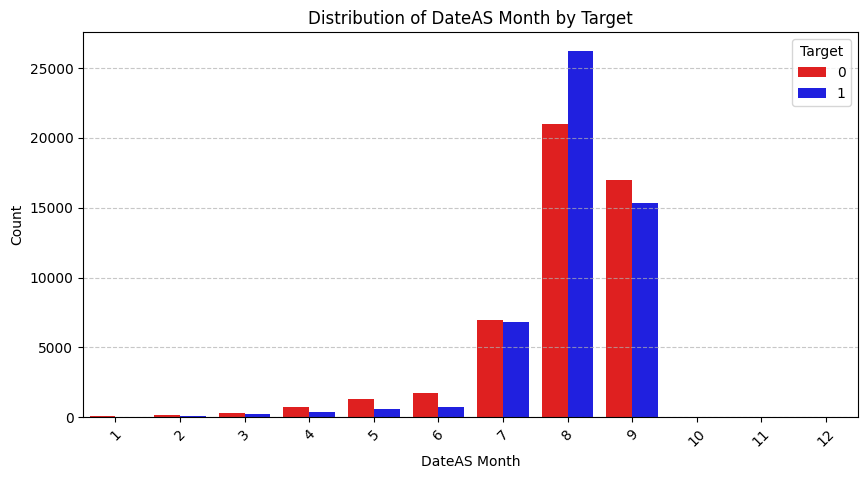

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateAS_month', hue='target', palette=['red', 'blue'])

plt.xlabel("DateAS Month")
plt.ylabel("Count")
plt.title("Distribution of DateAS Month by Target")
plt.legend(title="Target", labels=["0", "1"])

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Day

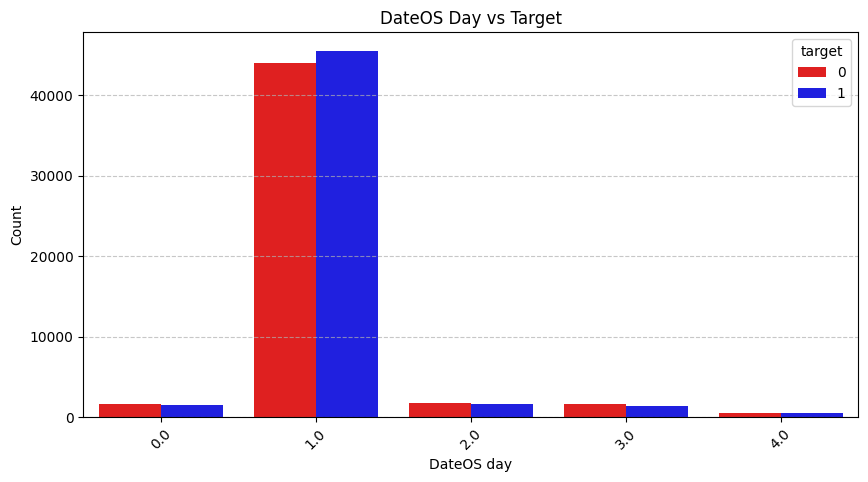

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateOS_day', hue='target', palette=['red','blue'])

plt.xlabel("DateOS day")
plt.ylabel("Count")
plt.title("DateOS Day vs Target")
plt.legend(title="target", labels=["0","1"])

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

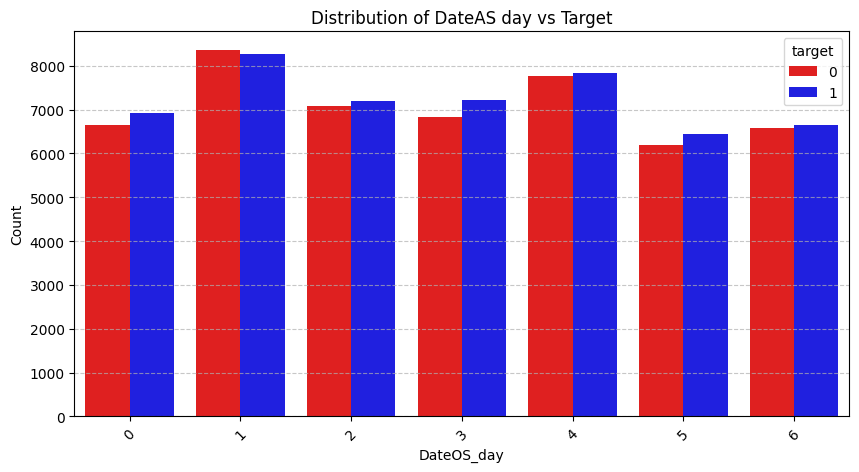

In [35]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='DateAS_day', hue='target', palette=['red','blue'])

plt.xlabel("DateOS_day")
plt.ylabel("Count")
plt.title("Distribution of DateAS day vs Target")
plt.legend(title="target", labels=["0","1"])

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Correlation with target

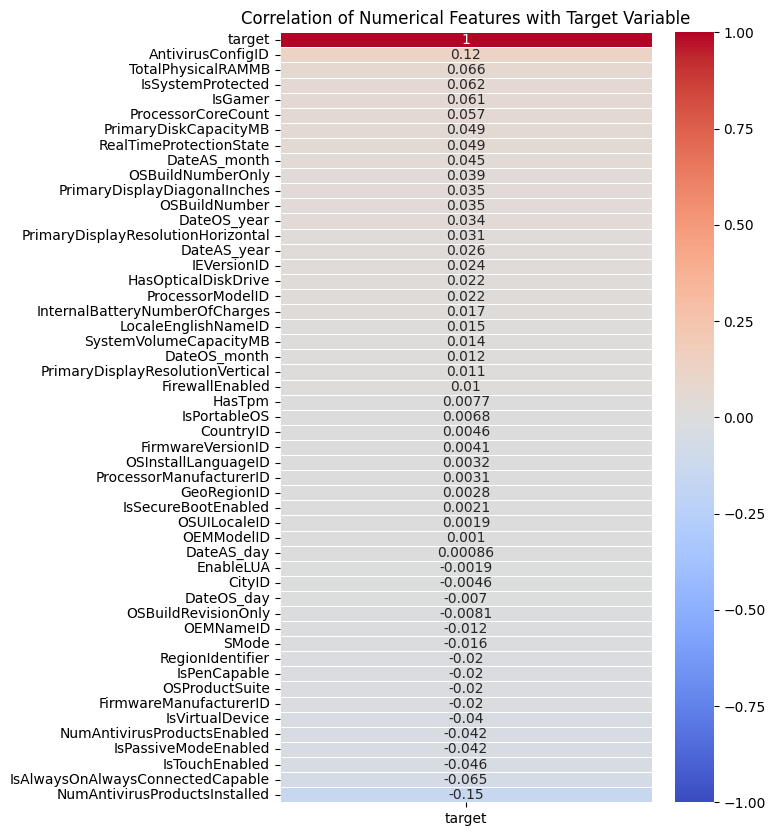

In [27]:
numerical_features = df.select_dtypes(include=['number'])

matrix = numerical_features.corr()
target = matrix['target'].dropna().sort_values(ascending=False) 

plt.figure(figsize=(6, 10))
sns.heatmap(target.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation of Numerical Features with Target Variable")
plt.show()

This shows a lot of numerical features are weakly correlated with the target variable.

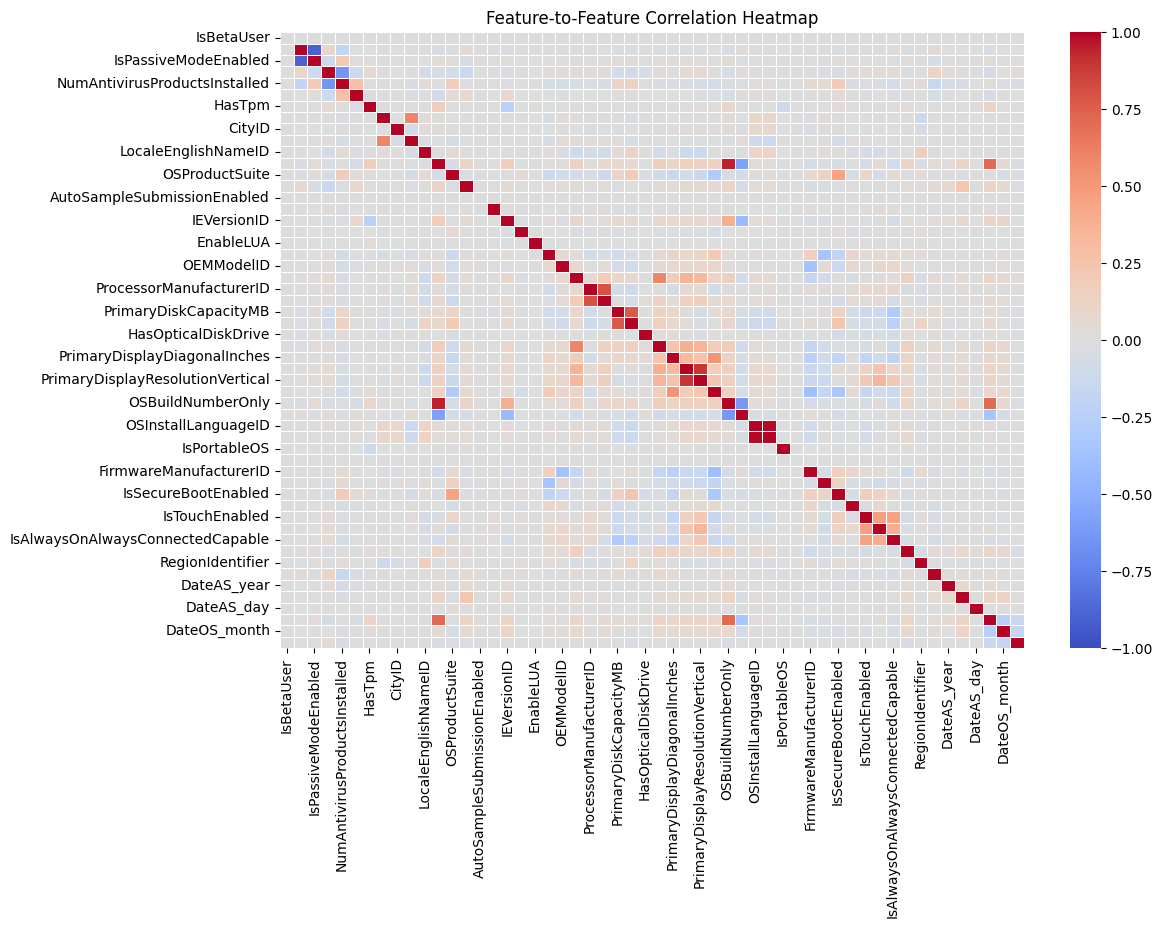

In [28]:
numerical_features = df.select_dtypes(include=['number'])
corr_matrix = numerical_features.corr()
corr_matrix = corr_matrix.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature-to-Feature Correlation Heatmap")
plt.show()

# Further Analysis

## Data Cleaning

In [12]:
cols = df.columns
pattern = r"(?i)unknown|unspecified"
df[cols] = df[cols].replace(pattern, np.nan, regex = True)

In [15]:
df.isnull().sum().sort_values(ascending=False)

AutoUpdateOptionsName                 26299
PrimaryDiskType                        5903
FlightRing                             2489
SMode                                   981
CityID                                  623
RegionIdentifier                        559
IsGamer                                 559
ChassisType                             515
InternalBatteryNumberOfCharges          515
FirmwareManufacturerID                  376
FirmwareVersionID                       334
IsFlightsDisabled                       326
OEMModelID                              228
OEMNameID                               212
FirewallEnabled                         166
TotalPhysicalRAMMB                      151
IsAlwaysOnAlwaysConnectedCapable        134
OSGenuineState                          115
OSInstallLanguageID                     113
PrimaryDiskCapacityMB                   110
SystemVolumeCapacityMB                  110
IEVersionID                             107
PowerPlatformRole               

In [16]:
df["GeoRegionID"] = df["GeoRegionID"].replace("Other", np.nan)

# Preprocessing

## Fixing Display Resolution

In [18]:
df["ScreenArea"] = df["PrimaryDisplayResolutionHorizontal"] * df["PrimaryDisplayResolutionVertical"]
df["AspectRatio"] = df["PrimaryDisplayResolutionHorizontal"] / df["PrimaryDisplayResolutionVertical"]

In [19]:
df.drop(columns=['PrimaryDisplayResolutionHorizontal','PrimaryDisplayResolutionVertical'], inplace=True)

In [20]:
q1 = df["PrimaryDisplayDiagonalInches"].quantile(0.25)
q3 = df["PrimaryDisplayDiagonalInches"].quantile(0.75)

def screen_size(size):
    if size <= q1:
        return 0
    elif size <= q3:
        return 1
    else:
        return 2

df["PrimaryDisplayDiagonalInches"] = df["PrimaryDisplayDiagonalInches"].apply(screen_size)

## Combining categories

In [21]:
df.replace({'Processor': {'x86': 'other', 'arm64': 'other'},
            'OSArchitecture': {'x86': 'other', 'arm64': 'other'},
            'OSGenuineState': {"INVALID_LICENSE": "other", "OFFLINE": "other"}
           }, inplace=True)

# Train Test Split

In [22]:
X = df.drop(columns=["target"])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(80000, 81) (80000,) (20000, 81) (20000,)


# Transformers

In [24]:
def frequency_encoder(X):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    return X.apply(lambda col: col.map(col.value_counts(normalize=True))) #Using normalize to get frequencies / total  

freqEnc_transformer = FunctionTransformer(frequency_encoder, validate=False, feature_names_out='one-to-one') #Used validate = False as I don't want Numpy array to be returned 

In [25]:
simpImp = SimpleImputer(strategy="most_frequent")
simpImpC = SimpleImputer(strategy="constant", fill_value=0)

oneHotE = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ordinalE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

minmax = MinMaxScaler()
robust = RobustScaler()

freq_scaler = Pipeline([
    ("impute", simpImp),
    ("scaler", minmax)
])

const_scaler = Pipeline([
    ("impute", simpImpC),
    ("scaler", minmax)
])


robust_imp = Pipeline([
    ("impute", simpImp),
    ("scaler", robust)
])

pipe_freq = Pipeline([
    ("impute", simpImpC),
    ("freq_encode", freqEnc_transformer)
])

pipe_ordinal = Pipeline([
   ("impute", simpImp),
   ("ordinal_encode", ordinalE)
])

oneHotPipe = Pipeline([
    ("impute", simpImp),
    ("onehot", oneHotE)
])

ct = ColumnTransformer([
    ('simpImp', simpImp, [
        'SMode','IsGamer','FirewallEnabled', 'IsSystemProtected', 'IsVirtualDevice', 'EnableLUA', 'DateAS_year', 'DateAS_month',
        'DateAS_day', 'DateOS_year', 'DateOS_month', 'DateOS_day', 'IsPassiveModeEnabled', 'HasTpm', 'IsAlwaysOnAlwaysConnectedCapable',
        'OSBuildRevisionOnly', 'IsPortableOS','IsTouchEnabled', 'IsPenCapable', 'IsSecureBootEnabled', 'PrimaryDisplayDiagonalInches' ]),
    
    ( 'freq_scaler', freq_scaler, [
        'CountryID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'OSBuildNumberOnly', 'OSUILocaleID',
        'RealTimeProtectionState', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 
        'CityID', 'GeoRegionID', 'ProcessorManufacturerID','RegionIdentifier' ] ),
    
    ( 'const_scaler', const_scaler, [
        'OEMNameID', 'OEMModelID', 'ProcessorCoreCount',  'ProcessorModelID', 'PrimaryDiskCapacityMB',  'SystemVolumeCapacityMB',  'TotalPhysicalRAMMB', 
        'OSInstallLanguageID', 'FirmwareManufacturerID', 'FirmwareVersionID', 'IEVersionID'] ),
    
    ('simpImpM', robust_imp, ['InternalBatteryNumberOfCharges', 'ScreenArea', 'AspectRatio']), 

    ('oneHot', oneHotPipe, ['ProductName', 'DeviceFamily', 'OSArchitecture', 'Processor', 'OSGenuineState', 'PrimaryDiskType']),

    ('targetEnc', ordinalE, ['EngineVersion', 'AppVersion', 'OSBuildLab', 'SignatureVersion', 'NumericOSVersion', 'OSVersion']),

    ( 'freq', pipe_freq, ['ChassisType','PowerPlatformRole', 'AutoUpdateOptionsName','FlightRing'] ),
    
    ('freqEnc', freqEnc_transformer, [
        'OsPlatformSubRelease', 'SKUEditionName', 'PlatformType', 'OSBranch', 'MDC2FormFactor',
        'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'LicenseActivationChannel']),
    
     ('imp', pipe_ordinal, ['AntivirusConfigID']) ], verbose_feature_names_out=False)

X_train_t = ct.fit_transform(X_train)
print(X_train_t.shape)

(80000, 80)


In [26]:
feature_names = ct.get_feature_names_out()
X_train_t = pd.DataFrame(X_train_t, columns=feature_names)
X_train_t.head()

,SMode,IsGamer,FirewallEnabled,IsSystemProtected,IsVirtualDevice,EnableLUA,DateAS_year,DateAS_month,DateAS_day,DateOS_year,DateOS_month,DateOS_day,IsPassiveModeEnabled,HasTpm,IsAlwaysOnAlwaysConnectedCapable,OSBuildRevisionOnly,IsPortableOS,IsTouchEnabled,IsPenCapable,IsSecureBootEnabled,PrimaryDisplayDiagonalInches,CountryID,LocaleEnglishNameID,OSBuildNumber,OSProductSuite,OSBuildNumberOnly,OSUILocaleID,RealTimeProtectionState,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,CityID,GeoRegionID,ProcessorManufacturerID,RegionIdentifier,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorModelID,PrimaryDiskCapacityMB,SystemVolumeCapacityMB,TotalPhysicalRAMMB,OSInstallLanguageID,FirmwareManufacturerID,FirmwareVersionID,IEVersionID,InternalBatteryNumberOfCharges,ScreenArea,AspectRatio,ProductName_mse,ProductName_win8defender,DeviceFamily_Windows.Desktop,DeviceFamily_Windows.Server,OSArchitecture_amd64,OSArchitecture_other,Processor_other,Processor_x64,OSGenuineState_IS_GENUINE,OSGenuineState_other,PrimaryDiskType_HDD,PrimaryDiskType_SSD,EngineVersion,AppVersion,OSBuildLab,SignatureVersion,NumericOSVersion,OSVersion,ChassisType,PowerPlatformRole,AutoUpdateOptionsName,FlightRing,OsPlatformSubRelease,SKUEditionName,PlatformType,OSBranch,MDC2FormFactor,OSEdition,OSSkuFriendlyName,OSInstallType,LicenseActivationChannel,AntivirusConfigID
0,0.0,0.0,1.0,1.0,0.0,1.0,2018.0,9.0,2.0,2018.0,5.0,1.0,0.0,1.0,0.0,48.0,0.0,0.0,0.0,0.0,1.0,0.764706,0.262411,0.938103,0.312500,0.916390,0.165605,0.875,0.0,0.25,0.080720,0.935593,0.444444,0.142857,0.346750,0.702213,0.0625,0.529924,0.062501,0.071716,0.031250,0.205128,0.511542,0.459059,0.357702,0.000000e+00,0.000000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,32.0,31.0,182.0,2166.0,194.0,0.0,0.594988,0.698638,0.238425,0.941187,0.457663,0.357538,0.98325,0.468488,0.64575,0.346000,0.353075,0.319738,0.522650,1310.0
1,0.0,0.0,1.0,1.0,0.0,1.0,2018.0,9.0,4.0,2018.0,8.0,1.0,0.0,1.0,0.0,228.0,0.0,0.0,0.0,0.0,1.0,0.266968,0.822695,0.938103,0.312500,0.916390,0.184713,0.875,0.0,0.25,0.063392,0.810169,0.444444,1.000000,0.809799,0.920008,0.0625,0.522778,0.020001,0.019767,0.007812,0.230769,0.131117,0.728038,0.357702,1.000000e+00,0.255372,-609.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,32.0,31.0,182.0,2098.0,189.0,0.0,0.207788,0.228738,0.450800,0.941187,0.457663,0.357538,0.98325,0.468488,0.03100,0.346000,0.353075,0.167125,0.522650,1310.0
2,0.0,0.0,1.0,1.0,0.0,1.0,2018.0,4.0,5.0,2018.0,3.0,1.0,0.0,1.0,0.0,309.0,0.0,0.0,0.0,1.0,0.0,0.769231,0.641844,0.855934,0.979167,0.805397,0.764331,0.875,0.0,0.25,0.573982,0.711864,0.444444,0.142857,0.440119,0.496149,0.0625,0.675748,0.125001,0.137795,0.031250,0.205128,0.579871,0.057968,0.289817,0.000000e+00,1.000000,-1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,26.0,26.0,175.0,911.0,164.0,0.0,0.594988,0.698638,0.238425,0.941187,0.296050,0.628300,0.98325,0.143613,0.64575,0.392788,0.392763,0.319738,0.391738,1310.0
3,0.0,1.0,1.0,1.0,0.0,1.0,2018.0,9.0,5.0,2018.0,8.0,1.0,0.0,1.0,0.0,228.0,0.0,0.0,0.0,1.0,1.0,0.674208,0.570922,0.938103,0.312500,0.916390,0.636943,0.875,0.0,0.25,0.130768,0.647458,0.444444,1.000000,0.440119,0.496151,0.0625,0.594015,0.016001,0.015710,0.031250,0.589744,0.579871,0.122484,0.357702,0.000000e+00,0.000000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,32.0,31.0,182.0,2542.0,189.0,0.0,0.594988,0.698638,0.450800,0.941187,0.457663,0.357538,0.98325,0.468488,0.64575,0.346000,0.353075,0.319738,0.391738,1310.0
4,0.0,1.0,1.0,1.0,0.0,1.0,2018.0,7.0,0.0,2018.0,7.0,1.0,0.0,1.0,0.0,165.0,0.0,0.0,0.0,0.0,1.0,0.393665,0.404255,0.938103,0.312500,0.916390,0.375796,0.875,0.0,0.25,0.217668,0.393220,0.444444,0.142857,0.086605,0.654102,0.1250,0.678428,0.125001,0.143719,0.031250,0.435897,0.131117,0.533270,0.357702,5.005859e-08,1.000000,-1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,31.0,29.0,182.0,1967.0,186.0,0.0,0.594988,0.698638,0.450800,0.941187,0.457663,0.357538,0.98325,0.468488,0.64575,0.346000,0.353075,0.144962,0.046288,1310.0


# Dropping Redundant Columns

Due to One Hot Encoding some columns add no value to dataset so dropping them 
* ProductName_mse
* DeviceFamily_Windows.Server
* OSArchitecture_other
* Processor_other
* OSGenuineState_other
* PrimaryDiskType_SSD

Mostly similar features

* OSBuildNumberOnly & OSBuildNumber are the same
* OSUILocaleID and OSInstallLanguageID
* OSSkuFriendlyName and OSEdition
* OSVersion and PlatformType
* OSBranch and OsPlatformSubRelease
* Processor_x64 and OSArchitecture_amd64

In [27]:
X_train_t.drop(columns=['ProductName_mse', 'DeviceFamily_Windows.Server', 'OSArchitecture_other', 'Processor_other', 'OSGenuineState_other', 'PrimaryDiskType_SSD',
                        'OSBuildNumberOnly','OSInstallLanguageID','OSSkuFriendlyName', 'OSVersion', 'Processor_x64', 'OSBranch'], inplace=True)

In [28]:
X_test = ct.transform(X_test)
X_test = pd.DataFrame(X_test, columns=ct.get_feature_names_out())

In [29]:
X_test.drop(columns=['ProductName_mse', 'DeviceFamily_Windows.Server', 'OSArchitecture_other', 'Processor_other', 'OSGenuineState_other', 'PrimaryDiskType_SSD',
'OSBuildNumberOnly','OSInstallLanguageID','OSSkuFriendlyName', 'OSVersion', 'Processor_x64', 'OSBranch'], inplace=True) 

In [30]:
print (X_train_t.shape, X_test.shape )

(80000, 68) (20000, 68)


# Feature Selection

## RFE - Random Forest

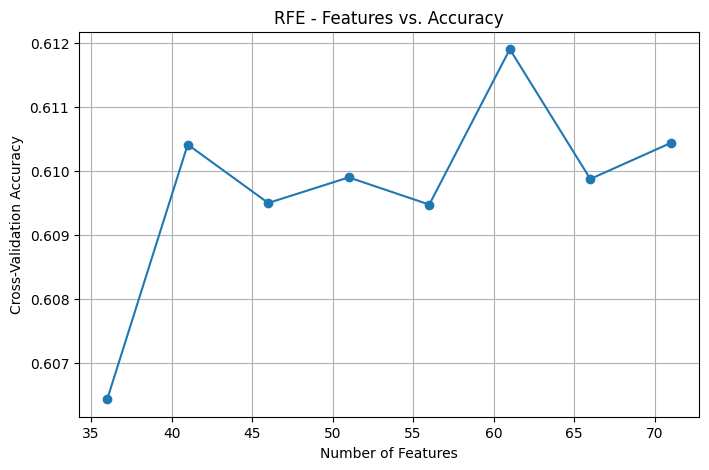

In [83]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
rfe = RFE(model, n_features_to_select=1, step=0.1)
rfe.fit(X_train_t, y_train)

features = np.array(X_train_t.columns)[np.argsort(rfe.ranking_)]

num_features, accuracies = [], []
for i in range(len(features), len(features) // 2, -5):
    score = np.mean(cross_val_score(model, X_train_t[features[:i]], y_train, cv=3, scoring="accuracy"))
    num_features.append(i)
    accuracies.append(score)

plt.figure(figsize=(8, 5))
plt.plot(num_features, accuracies, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFE - Features vs. Accuracy")
plt.grid()
plt.show()

In [84]:
best_index = np.argmax(accuracies)
best_feature_count = num_features[best_index]
best_accuracy = accuracies[best_index]

print("Optimal Number of Features:", best_feature_count, "Accuracy:", best_accuracy)

final_features = features[:best_feature_count]
print("Final Selected Features:", final_features.tolist())

Optimal Number of Features: 61 Accuracy: 0.6118999930036314
Final Selected Features: ['SignatureVersion', 'AntivirusConfigID', 'SystemVolumeCapacityMB', 'CountryID', 'ProcessorModelID', 'FirmwareVersionID', 'OEMModelID', 'CityID', 'NumericOSVersion', 'OEMNameID', 'PrimaryDiskCapacityMB', 'LocaleEnglishNameID', 'GeoRegionID', 'OSBuildRevisionOnly', 'DateAS_day', 'TotalPhysicalRAMMB', 'FirmwareManufacturerID', 'OSUILocaleID', 'RegionIdentifier', 'AppVersion', 'DateOS_month', 'OSInstallType', 'AspectRatio', 'OSBuildLab', 'ChassisType', 'NumAntivirusProductsInstalled', 'OSEdition', 'ScreenArea', 'IEVersionID', 'EngineVersion', 'AutoUpdateOptionsName', 'LicenseActivationChannel', 'MDC2FormFactor', 'ProcessorCoreCount', 'DateAS_month', 'PrimaryDisplayDiagonalInches', 'PowerPlatformRole', 'DateOS_day', 'IsGamer', 'OSBranch', 'OSBuildNumber', 'IsSecureBootEnabled', 'OsPlatformSubRelease', 'InternalBatteryNumberOfCharges', 'OSProductSuite', 'SKUEditionName', 'IsTouchEnabled', 'OSGenuineState_IS

## RFE - XGBoost

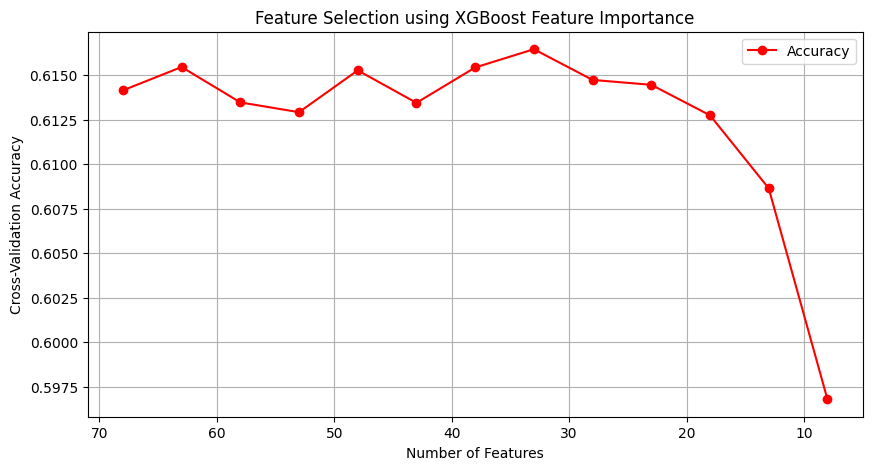

In [108]:
model = XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric="logloss")

model.fit(X_train_t, y_train)
feature_importances = model.feature_importances_

sorted_features = np.array(X_train_t.columns)[np.argsort(-feature_importances)]

num_features = []
accuracies = []

for i in range(len(sorted_features), 4, -5):  
    selected_features = sorted_features[:i]  
    X_train_selected = X_train_t[selected_features]

    score = np.mean(cross_val_score(model, X_train_selected, y_train, cv=3, scoring="accuracy"))

    num_features.append(i)
    accuracies.append(score)

plt.figure(figsize=(10, 5))
plt.plot(num_features, accuracies, marker="o", linestyle="-", color="r", label="Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Feature Selection using XGBoost Feature Importance")
plt.gca().invert_xaxis() 
plt.grid()
plt.legend()
plt.show()

In [109]:
best_index = np.argmax(accuracies)
best_feature_count = num_features[best_index]
best_accuracy = accuracies[best_index]

print("Optimal Number of Features:", best_feature_count, "Accuracy:", best_accuracy)


final_features = sorted_features[:best_feature_count]
print("Final Selected Features:", final_features.tolist())

Optimal Number of Features: 33 Accuracy: 0.6164624720672953
Final Selected Features: ['NumAntivirusProductsInstalled', 'IsAlwaysOnAlwaysConnectedCapable', 'IsVirtualDevice', 'TotalPhysicalRAMMB', 'OSArchitecture_amd64', 'AspectRatio', 'IsGamer', 'DateAS_month', 'OSInstallType', 'AntivirusConfigID', 'IsPassiveModeEnabled', 'SignatureVersion', 'AppVersion', 'MDC2FormFactor', 'IsTouchEnabled', 'LicenseActivationChannel', 'RealTimeProtectionState', 'NumAntivirusProductsEnabled', 'EngineVersion', 'PrimaryDiskCapacityMB', 'FirewallEnabled', 'OSEdition', 'InternalBatteryNumberOfCharges', 'IsSystemProtected', 'LocaleEnglishNameID', 'ProcessorManufacturerID', 'PrimaryDisplayDiagonalInches', 'DateOS_year', 'NumericOSVersion', 'IsSecureBootEnabled', 'DateOS_day', 'OSUILocaleID', 'OSBuildLab']


## RFE - LightGBM

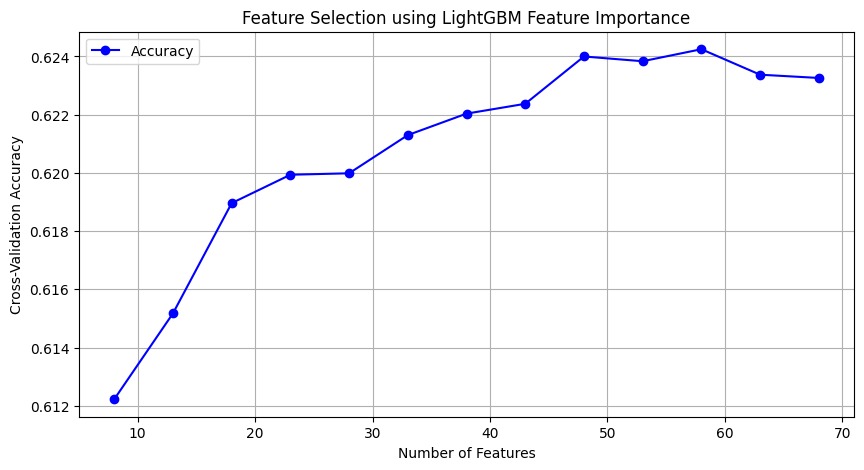

In [222]:
model = LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

model.fit(X_train_t, y_train)
feature_importances = model.feature_importances_

sorted_features = np.array(X_train_t.columns)[np.argsort(-feature_importances)]

num_features = []
accuracies = []

for i in range(len(sorted_features), 4, -5):  
    selected_features = sorted_features[:i]  
    X_train_selected = X_train_t[selected_features]

    score = np.mean(cross_val_score(model, X_train_selected, y_train, cv=3, scoring="accuracy"))

    num_features.append(i)
    accuracies.append(score)

plt.figure(figsize=(10, 5))
plt.plot(num_features, accuracies, marker="o", linestyle="-", color="b", label="Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Feature Selection using LightGBM Feature Importance")

plt.grid()
plt.legend()
plt.show()

In [223]:
best_index = np.argmax(accuracies)
best_feature_count = num_features[best_index]
best_accuracy = accuracies[best_index]

print("Number of Features:", best_feature_count, "Accuracy:", best_accuracy)

final_features = sorted_features[:best_feature_count]
print("Final Selected Features:", final_features.tolist())

Number of Features: 58 Accuracy: 0.6242499759760277
Final Selected Features: ['SignatureVersion', 'AntivirusConfigID', 'SystemVolumeCapacityMB', 'AppVersion', 'ProcessorModelID', 'LocaleEnglishNameID', 'CityID', 'CountryID', 'FirmwareVersionID', 'OSBuildRevisionOnly', 'OEMModelID', 'PrimaryDiskCapacityMB', 'OSInstallType', 'TotalPhysicalRAMMB', 'NumericOSVersion', 'OSUILocaleID', 'GeoRegionID', 'ScreenArea', 'InternalBatteryNumberOfCharges', 'RegionIdentifier', 'OEMNameID', 'LicenseActivationChannel', 'DateAS_month', 'NumAntivirusProductsInstalled', 'FirmwareManufacturerID', 'OSEdition', 'DateOS_month', 'OSBuildLab', 'IsGamer', 'AspectRatio', 'EngineVersion', 'ChassisType', 'RealTimeProtectionState', 'IEVersionID', 'AutoUpdateOptionsName', 'DateOS_day', 'ProcessorCoreCount', 'DateAS_day', 'IsVirtualDevice', 'MDC2FormFactor', 'PrimaryDisplayDiagonalInches', 'OSArchitecture_amd64', 'SKUEditionName', 'FirewallEnabled', 'PowerPlatformRole', 'IsTouchEnabled', 'IsSystemProtected', 'NumAntivi

LightBGM has the best accuracy.

# Selected Feature

In [31]:
selected = ['SignatureVersion', 'AntivirusConfigID', 'SystemVolumeCapacityMB', 'AppVersion', 'ProcessorModelID', 'LocaleEnglishNameID', 'CityID', 'CountryID', 'FirmwareVersionID', 'OSBuildRevisionOnly', 'OEMModelID', 'PrimaryDiskCapacityMB', 'OSInstallType', 'TotalPhysicalRAMMB', 'NumericOSVersion', 'OSUILocaleID', 'GeoRegionID', 'ScreenArea', 'InternalBatteryNumberOfCharges', 'RegionIdentifier', 'OEMNameID', 'LicenseActivationChannel', 'DateAS_month', 'NumAntivirusProductsInstalled', 'FirmwareManufacturerID', 'OSEdition', 'DateOS_month', 'OSBuildLab', 'IsGamer', 'AspectRatio', 'EngineVersion', 'ChassisType', 'RealTimeProtectionState', 'IEVersionID', 'AutoUpdateOptionsName', 'DateOS_day', 'ProcessorCoreCount', 'DateAS_day', 'IsVirtualDevice', 'MDC2FormFactor', 'PrimaryDisplayDiagonalInches', 'OSArchitecture_amd64', 'SKUEditionName', 'FirewallEnabled', 'PowerPlatformRole', 'IsTouchEnabled', 'IsSystemProtected', 'NumAntivirusProductsEnabled', 'IsSecureBootEnabled', 'OSGenuineState_IS_GENUINE', 'SMode', 'IsAlwaysOnAlwaysConnectedCapable', 'PrimaryDiskType_HDD', 'DateOS_year', 'IsPenCapable', 'OSBuildNumber', 'IsPassiveModeEnabled', 'OSProductSuite']

In [32]:
X_train_selected = X_train_t[selected]
X_test_selected = X_test[selected]

In [33]:
X_train_selected.shape

(80000, 58)

# Model Selection

In [232]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1),
    "DecisionTrees": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

RandomForest Accuracy: 0.6214
XGBoost Accuracy: 0.6220
LightGBM Accuracy: 0.6290
DecisionTrees Accuracy: 0.5453
LogisticRegression Accuracy: 0.5708


So, the final three models are
* RandomForest Accuracy: 0.6214
* XGBoost Accuracy: 0.6220
* LightGBM Accuracy: 0.6290

# Finding hyperparameters

## LGBMClassifier HPT

In [95]:
estimator = LGBMClassifier(random_state=42, verbosity=-1)
param_grid = {
    'n_estimators': [350, 500, 700, 1000],
    'max_depth': [3, 5, 10, 15],
    'min_child_samples': [5, 10, 20, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

lgbm = RandomizedSearchCV(estimator, param_grid, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
lgbm.fit(X_train_t, y_train)

print("LGBM Parameters", lgbm.best_params_)
print("LGBM Accuracy", lgbm.best_score_)

LGBM Parameters {'n_estimators': 350, 'min_child_samples': 50, 'max_depth': 15, 'learning_rate': 0.05}
LGBM Accuracy 0.6273375


## XGBoost HPT

In [93]:
param_grid = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0] #features selected randomly by the tree 
}

estimator = XGBClassifier(random_state=42)
xgb = RandomizedSearchCV(estimator, param_grid, cv=5, n_iter=30, scoring='accuracy', n_jobs=-1)
xgb.fit(X_train_selected, y_train)

print("XGBoost Parameters", xgb.best_params_)
print("XGBoost Accuracy", xgb.best_score_)

XGBoost Parameters {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
XGBoost Accuracy 0.6276750000000001


## RandomForest HPT

In [34]:
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

estimator = RandomForestClassifier(random_state=42)
rf = RandomizedSearchCV(estimator, param_grid, cv=5, n_iter=30, scoring='accuracy', n_jobs=-1)
rf.fit(X_train_selected, y_train)

print("RandomForest Parameters", rf.best_params_)

RandomForest Parameters {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}


In [39]:
print("RandomForest Accuracy", rf.best_score_)

RandomForest Accuracy 0.6214500000000001


# Model 1: LightGBM 

In [36]:
lgbm = LGBMClassifier(n_estimators=350, max_depth=10, min_child_samples=50, verbosity=-1,random_state=42,learning_rate=0.05)

lgbm.fit(X_train_selected, y_train)  

LGBMClassifier(learning_rate=0.05, max_depth=10, min_child_samples=50,
               n_estimators=350, random_state=42, verbosity=-1)

In [37]:
y_lgbm_pred = lgbm.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_lgbm_pred)

print(f"Final LightGBM Test Accuracy: {test_accuracy:.4f}")

Final LightGBM Test Accuracy: 0.6298


# Model 2: XGBoost 

In [91]:
xgboost = XGBClassifier(n_estimators=800, max_depth=5, learning_rate=0.05, colsample_bytree=0.8, random_state=42)

xgboost.fit(X_train_selected, y_train)  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [92]:
y_xgboost_pred = xgboost.predict(X_test_selected)
test_accuracy2 = accuracy_score(y_test, y_xgboost_pred)

print(f"Final XGBoost Test Accuracy: {test_accuracy2:.4f}")

Final XGBoost Test Accuracy: 0.6272


# Model 3: RandomForest

In [48]:
rf = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_depth=30, random_state=42)

rf.fit(X_train_selected, y_train)  

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=800, random_state=42)

In [50]:
y_rf_pred = rf.predict(X_test_selected)
test_accuracy3 = accuracy_score(y_test, y_rf_pred)

print(f"Final RandomForest Test Accuracy: {test_accuracy3:.4f}")

Final RandomForest Test Accuracy: 0.6242


# Model Performance Comparison

In [53]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_depth=30, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=800, max_depth=7, learning_rate=0.01, colsample_bytree=0.6, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1, learning_rate=0.05,max_depth=10, min_child_samples=50, n_estimators=350)
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

RandomForest Accuracy: 0.6242
XGBoost Accuracy: 0.6277
LightGBM Accuracy: 0.6298


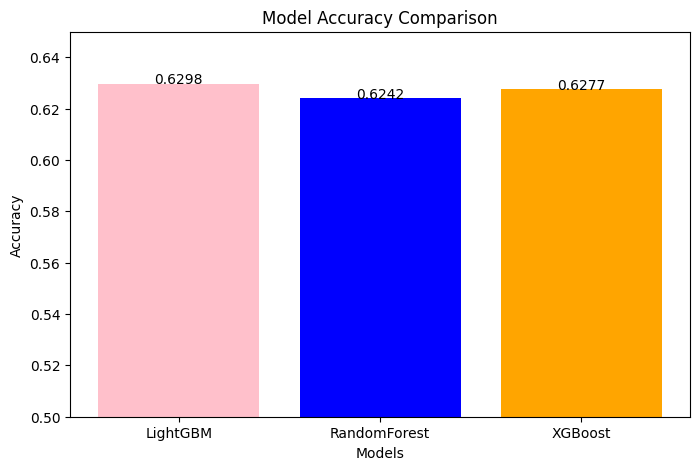

In [54]:
model = ['LightGBM', 'RandomForest', 'XGBoost']
accuracy = [0.6298, 0.6242, 0.6277]

plt.figure(figsize=(8, 5))
plt.bar(model, accuracy, color=['pink', 'blue', 'orange'])
plt.ylim(0.5, 0.65)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for i, acc in enumerate(accuracy):
    plt.text(i, acc, f"{acc:.4f}", ha='center')

plt.show()

## Training time and prediction time

In [58]:
for name, model in models.items():
    start = time.time()
    model.fit(X_train_selected, y_train)
    train_time = time.time() - start

    start = time.time()
    model.predict(X_test_selected)
    predict_time = time.time() - start

    print(name, "Training time:", train_time, "s Prediction time:", predict_time,"s")

RandomForest Training time: 204.83756709098816 s Prediction time: 5.422480583190918 s
XGBoost Training time: 10.41964340209961 s Prediction time: 0.22912836074829102 s
LightGBM Training time: 3.5283946990966797 s Prediction time: 0.26099228858947754 s


### Insight - 

* LightGBM is the fastest in terms of training time and has lower prediction time which makes it ideal for large datatsets
* Random Forest has a longer training time and prediction time making it ideal for smaller datasets

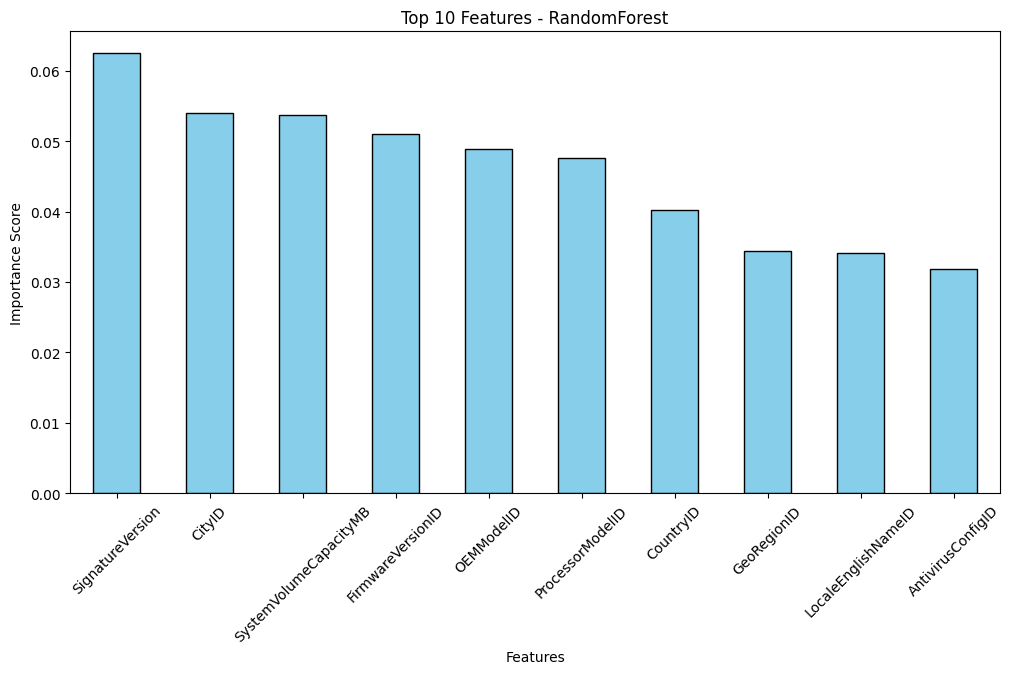

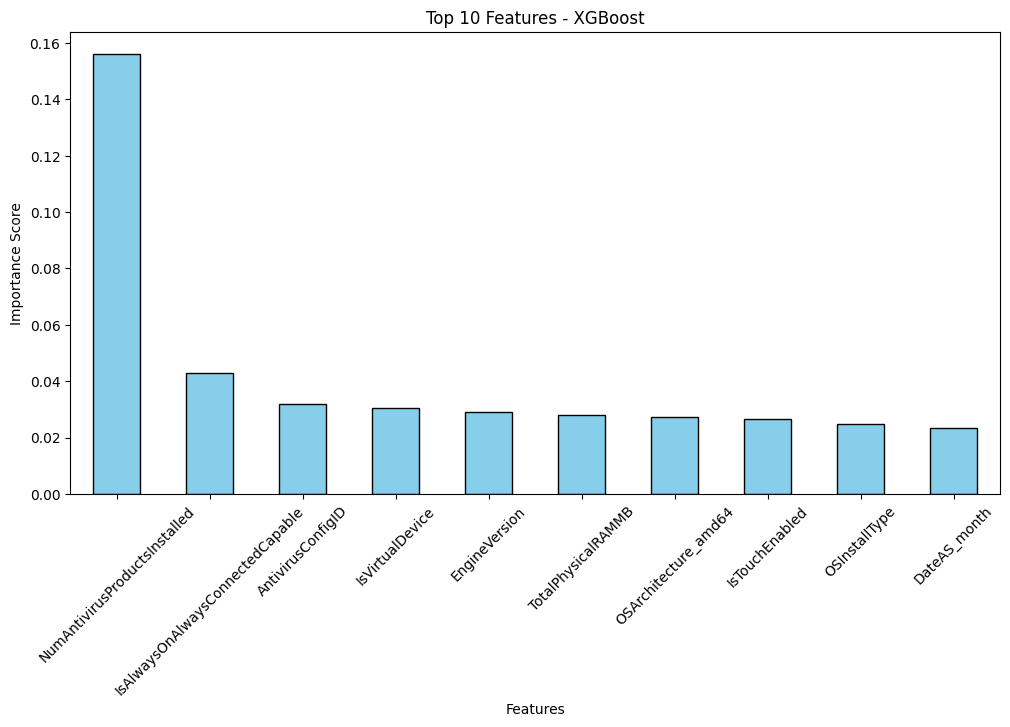

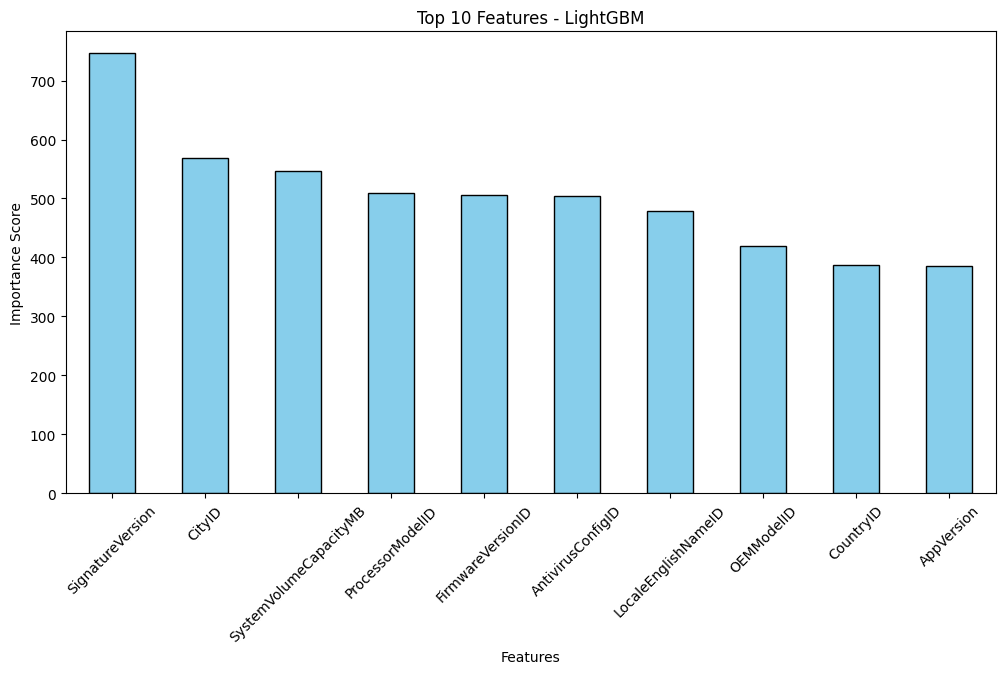

In [59]:
for name, model in models.items():
    model.fit(X_train_t, y_train)
    importance = pd.Series(model.feature_importances_, index=X_train_t.columns).sort_values(ascending=False)
 
    plt.figure(figsize=(12, 6))
    importance.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top 10 Features - {name}")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.xticks(rotation=45)
    plt.show()

# Confusion Matrix

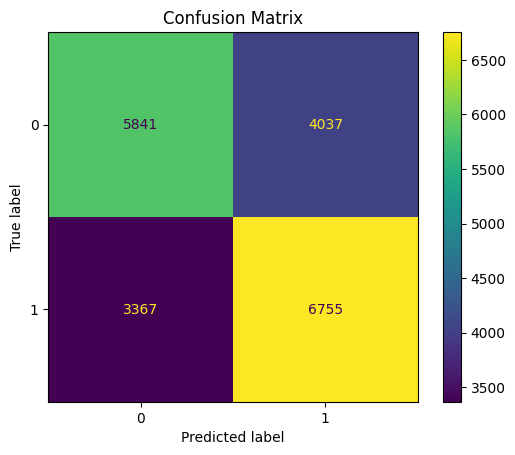

In [88]:
y_pred = lgbm.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot() 
plt.title("Confusion Matrix")
plt.show()

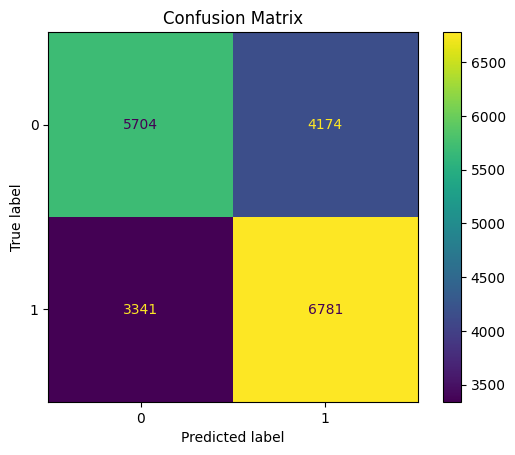

In [89]:
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot() 
plt.title("Confusion Matrix")
plt.show()

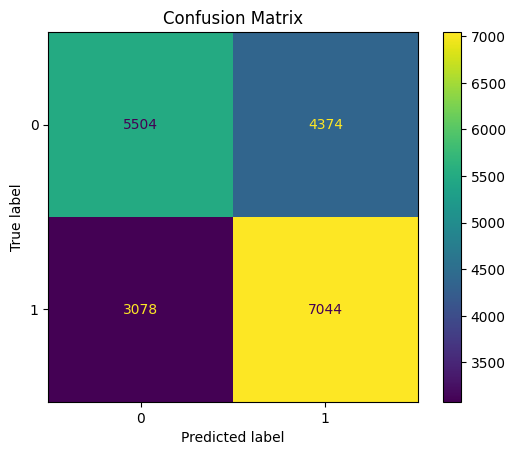

In [90]:
y_pred = xgboost.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot() 
plt.title("Confusion Matrix")
plt.show()

### Insight

* AntivirusConfigID is the only feature in top 10 features of all the three models
* Random Forest focuses on geographical features
* XGBoost relies more on system properties
* LightGBM depends on hardware, security settings, and OS updates along with country & city ID

So, finally I reach the conclusion that LightGBM has the best accuracy hence the best model for this problem among the models I chose for this problem

### Final Insights

LightGBM
* LightGBM has the highest accuracy, but the scores for all three models are very close.
* LightGBM’s top contributing features include AntivirusConfigID and hardware configurations (FirmwareVersionID, ProcessorModelID), and some regional factors (CityID, CountryID).
* It is well-suited for large datasets due to its fast training speed and also the mix of hardware and regional factors makes it ideal where sytem configurations and region are important. Hence, good for providing predictions for this dataset where there are a lot of hardware/software configurations and very few features with user behaviour.


Random Forest
* Random Forest primarily emphasizes regional and location-based features (CityID, CountryID, GeoRegionID, LocaleEnglishNameID) along with hardware configurations.
* It is best suited for problems where geographic factors and hardware configurations are key considerations but ideal for medium to small datasets

XGBoost
* XGBoost focuses more on system-specific configurations (NumAntivirusProductsInstalled, OSInstallType, IsVirtualDevice) while also considering hardware features (OSArchitecture, TotalPhysicalRAMMB, EngineVersion) and user behaviour (IsGamer).
* XGBoost is well-suited for scenarios requiring detailed system profiling and security insights. However, for this dataset, its effectiveness is reduced since 'IsVirtualDevice' has a very low count for 'Yes', 'OSInstallType' has mostly a single category, and while 'NumAntivirusProductsInstalled' varies, 'NumAntivirusProductsEnabled' is mostly 1.

# Final Model

# Data & Model Key Insights

### Data Insights

Dataset mainly includes the following features -
* Hardware build & software configurations
* Region based features
* Date & time of malware & OS updates
* OS related features
* OS is limited to Windows OS only
* Antivirus information is limited to two products - Windows defender & Windows MSE (now defunct)
* Too many columns have the "type of device"


Interesting Points 

* As seen in EDA, in most of the features one type of data dominates the column but is responsible for around 50 - 55% of malware infection. There by, making it difficult to ascertain the features which directly contribute to infection.
* Data lacks human interaction/behavious - malware infection comes from various sources but one of the most comman way of getting an infection is untimely updates of OS & antivirus systems resulting in failure to catch them.

### Final Model Insights - Blended RandomForest & LightGBM

1. Model Selection & Blending Strategy
- Instead of using a single model, I used RandomForest and LightGBM.  
- The final model is a weighted average (0.5 RF + 0.5 LGBM) to get the best of strengths of both models.  
- LightGBM is prone to overfitting but this blended model gives generalizable predictions.  

2. Common Contributing Features   
- Security-related features:AntivirusConfigID, SignatureVersion  
- System specifications: SystemVolumeCapacityMB, ProcessorModelID, FirmwareVersionID  
- Regional factors: CountryID, CityID, LocaleEnglishNameID  

3. Strengths of the Final Model
- Better Generalization: Random forest is robust to noise and LGBM is better at capturing patterns
- Improved Accuracy: Final accuracy is higher than either model alone
- Robustness: LightGBM is fast and efficient whereas RandomForest’s can capture non-linear relationships  

# Final Submission

## Test data preprocessing

In [64]:
test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [65]:
cols = test.columns
pattern = r"(?i)unknown|unspecified"
test[cols] = test[cols].replace(pattern, np.nan, regex = True)

In [66]:
test['DateAS'] = pd.to_datetime(test['DateAS'])
test['DateOS'] = pd.to_datetime(test['DateOS'])

test['DateAS_year'] = test['DateAS'].dt.year
test['DateAS_month'] = test['DateAS'].dt.month
test['DateAS_day'] = test['DateAS'].dt.dayofweek

test['DateOS_year'] = test['DateOS'].dt.year
test['DateOS_month'] = test['DateOS'].dt.month
test['DateOS_day'] = test['DateOS'].dt.dayofweek

In [67]:
test["ScreenArea"] = test["PrimaryDisplayResolutionHorizontal"] * test["PrimaryDisplayResolutionVertical"]
test["AspectRatio"] = test["PrimaryDisplayResolutionHorizontal"] / test["PrimaryDisplayResolutionVertical"]

test.drop(columns=['PrimaryDisplayResolutionHorizontal','PrimaryDisplayResolutionVertical'], inplace=True)
test["PrimaryDisplayDiagonalInches"] = test["PrimaryDisplayDiagonalInches"].apply(screen_size)

In [68]:
test.replace({'Processor': {'x86': 'other', 'arm64': 'other'},
            'OSArchitecture': {'x86': 'other', 'arm64': 'other'},
            'OSGenuineState': {"INVALID_LICENSE": "other", "OFFLINE": "other"}
           }, inplace=True)

In [69]:
test.shape

(10000, 81)

In [70]:
test_data = ct.transform(test)
names = ct.get_feature_names_out()
test_data = pd.DataFrame(test_data, columns=names)

In [72]:
test_data = test_data[selected]

In [73]:
test_data.shape

(10000, 58)

# Final Submission

In [79]:
pred = lgbm.predict(test_data)
submission = pd.DataFrame({"id": range(0, test_data.shape[0]), 
                           "target": pred})

submission.to_csv('submission.csv', index=False)
submission

,id,target
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,1
9997,9997,0
9998,9998,0


## Thank you!